# Audio Classification 
Classify audios using Tensorflow with a CNN model

# Libraries

In [49]:
# import all libraries
import librosa
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import os
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from model import ConvModel
from librosa import display
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import IPython.display as ipd
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from keras.layers import *
from keras.models import Sequential, load_model 

# Dataset

### 1. See some samples 

In [2]:
# define path of some datas
sample_path_1 = "data/UrbanSound8K/audio/fold5/100032-3-0-0.wav"
sample_path_2 = "data/UrbanSound8K/audio/fold5/100263-2-0-117.wav"

# display them
print("Dog bark sample \n")
ipd.Audio(sample_path_1)

Dog bark sample 



In [3]:
print("Children playing sample \n")
ipd.Audio(sample_path_2)

Children playing sample 



##### Draw wave plot and spectrogram

In [4]:
def draw_waveplot(data, sr, audio_label):
    """
    Draw wave plot for audio
    """
    # define the figure
    plt.figure(figsize=(12,5))
    # set the title
    plt.title(f'waveplot for {audio_label}', size=15)
    # display the wave plot
    display.waveshow(y=data, sr=sr)

In [5]:
def draw_spectogram(data, sr, label):
    """
    Draw spectrogram
    """
    # get the audio
    audio = librosa.stft(data)
    # convert amplitude to decibles
    audio_db = librosa.amplitude_to_db(abs(audio))
    # define the figure
    plt.figure(figsize=(12,5))
    # set teh title
    plt.title(f'spectrogram for {label}', size=15)
    # display spectrogram
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

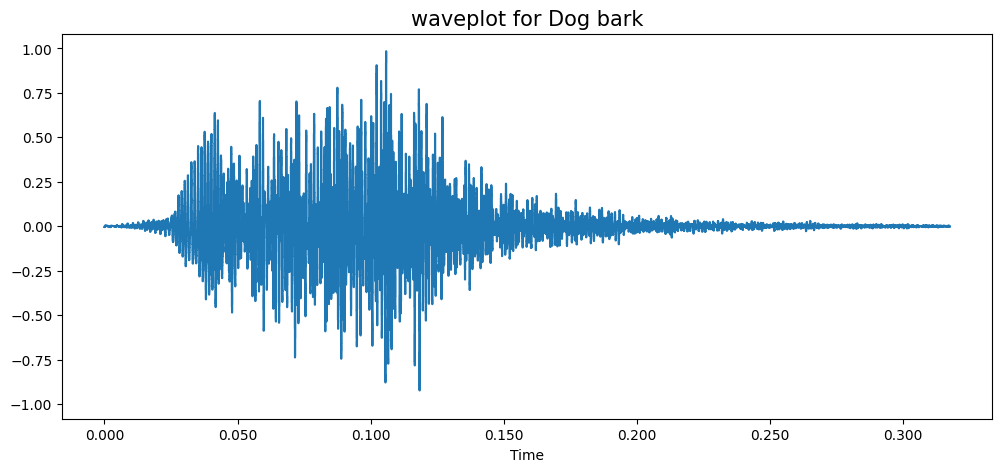

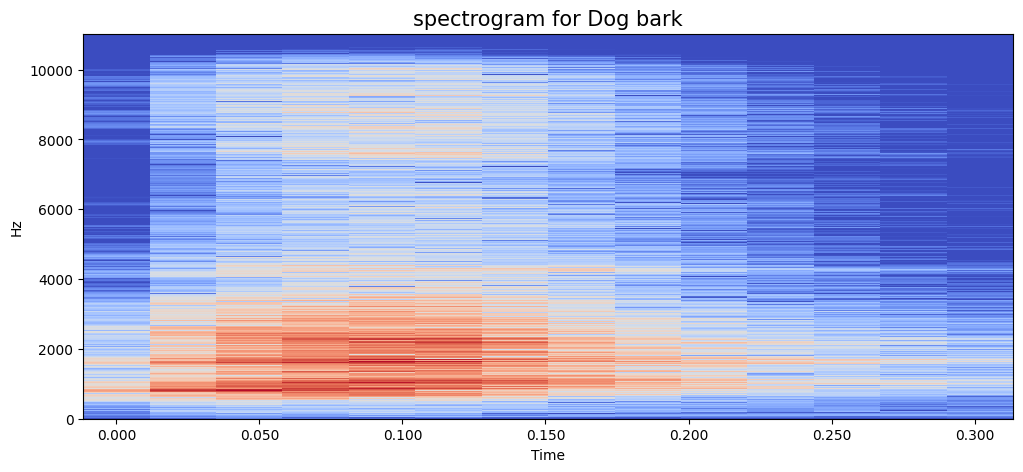

In [6]:
data, sample_rate = librosa.load(sample_path_1)
draw_waveplot(data, sample_rate, "Dog bark")
draw_spectogram(data, sample_rate, "Dog bark")

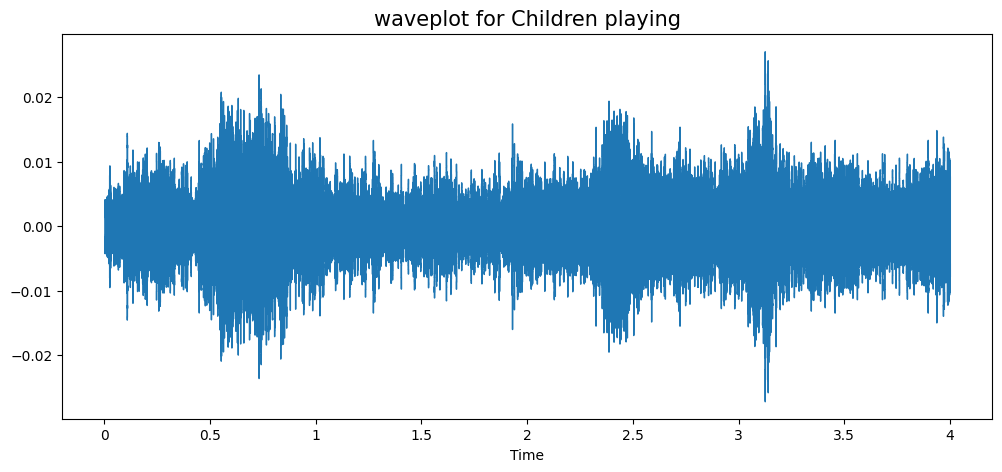

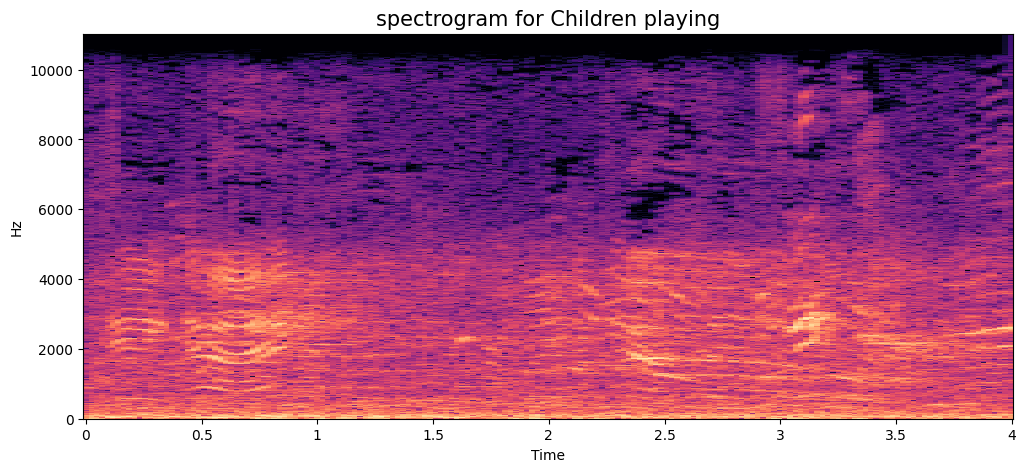

In [7]:
data, sample_rate = librosa.load(sample_path_2)
draw_waveplot(data, sample_rate, "Children playing")
draw_spectogram(data, sample_rate, "Children playing")

### 2. Load labels

In [8]:
# load the csv file which contains the labels
labels_df = pd.read_csv("data/UrbanSound8K/metadata/UrbanSound8K.csv")

# show it!
labels_df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


### 4. Load the audios, Preprocess

In [9]:
def extract_mfcc(audio_path):
    """
    Extract MFCC from the audio
    """
    # load audio file
    audio, sample_rate = librosa.load(audio_path, res_type="kaiser_fast")

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfcc = np.mean(mfcc.T, axis=0)

    return mfcc

In [10]:
# define a list for features
features = []

# loop over all data
for index_num, row in labels_df.iterrows():
    # get the file name and class
    filename = os.path.join(os.path.abspath("data/UrbanSound8K/audio"),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_label = row["class"]
    # extract features
    extract = extract_mfcc(filename)
    
    # Say how many audios has been preprocessed
    if index_num % 500 == 0:
        print(f"{index_num} audios has been preprocessed")

    # add extracted features to the list 
    features.append([extract, class_label])

0 audios has been preprocessed
500 audios has been preprocessed
1000 audios has been preprocessed
1500 audios has been preprocessed
2000 audios has been preprocessed
2500 audios has been preprocessed
3000 audios has been preprocessed
3500 audios has been preprocessed


C:\Users\yasin\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)


4000 audios has been preprocessed
4500 audios has been preprocessed
5000 audios has been preprocessed
5500 audios has been preprocessed
6000 audios has been preprocessed
6500 audios has been preprocessed
7000 audios has been preprocessed
7500 audios has been preprocessed
8000 audios has been preprocessed


C:\Users\yasin\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\yasin\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


8500 audios has been preprocessed


In [18]:
# create a dataframe for features
features_df = pd.DataFrame(features, columns=["Feature", "Class"])
features_df.head()

,Feature,Class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [19]:
# put datas into lists for inputs and targets (X and y)
X = np.array(features_df["Feature"].tolist())
y = np.array(features_df["Class"].tolist())

In [20]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [21]:
# define label encoder
label_encoder = LabelEncoder()

In [22]:
# categorize labels (Convert them into intiger)
y = to_categorical(label_encoder.fit_transform(y))

In [23]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### 5. Split the data

##### Split train and test

In [24]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [25]:
# split training data into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [26]:
# see the shapes
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")
print(f"Shape of validation data: {X_validation.shape}")

Shape of training data: (6308, 40)
Shape of testing data: (1310, 40)
Shape of validation data: (1114, 40)


In [27]:
# Add another dimention (axis 2) so we can pass the data to CNN model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_validation = np.expand_dims(X_validation, axis=2)

In [28]:
# see the shapes
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")
print(f"Shape of validation data: {X_validation.shape}")

Shape of training data: (6308, 40, 1)
Shape of testing data: (1310, 40, 1)
Shape of validation data: (1114, 40, 1)


Now you can see that another dimension is added to the file

# Model and Training

### 1. Hyperparameters and variables

In [29]:
# define hyperparameters and vars
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = 10

### 2. Create the model

In [39]:
# define the model
model = Sequential()

# Add the first Conv block (input block)
model.add(Conv1D(256, kernel_size=5, padding="same", strides=1, input_shape=(40, 1), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=1, padding="same"))

# Add second Conv block
model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=1, padding="same"))

# Add final Conv block
# Add second Conv block
model.add(Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=1, padding="same"))

# Add a Dropout before adding Dense layers
model.add(Dropout(0.3))

# Flatten
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
# Add a dropout
model.add(Dropout(0.2))

# Final classification layers
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [31]:
# see the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 batch_normalization (BatchN  (None, 40, 256)          1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 256)           327936    
                                                                 
 batch_normalization_1 (Batc  (None, 40, 256)          1024      
 hNormalization)                                                 
                                                        

In [32]:
# compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### 3. Train

In [33]:
# define learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [34]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, validation_data=(X_validation, y_validation), epochs=EPOCHS, verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/150
198/198 [==============================] - 21s 34ms/step - loss: 1.4371 - accuracy: 0.5225 - val_loss: 1.2705 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 2/150
198/198 [==============================] - 5s 25ms/step - loss: 1.0833 - accuracy: 0.6308 - val_loss: 1.2558 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 3/150
198/198 [==============================] - 5s 25ms/step - loss: 0.9538 - accuracy: 0.6779 - val_loss: 1.0964 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 4/150
198/198 [==============================] - 4s 21ms/step - loss: 0.8178 - accuracy: 0.7246 - val_loss: 1.0056 - val_accuracy: 0.6921 - lr: 0.0010
Epoch 5/150
198/198 [==============================] - 7s 36ms/step - loss: 0.7589 - accuracy: 0.7446 - val_loss: 0.9169 - val_accuracy: 0.6876 - lr: 0.0010
Epoch 6/150
198/198 [==============================] - 4s 23ms/step - loss: 0.6906 - accuracy: 0.7662 - val_loss: 0.9749 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 7/150
198/198 [==============================] - 7s

In [36]:
# save the model
model.save("model.h5")

##### Visualize loss and accuracy

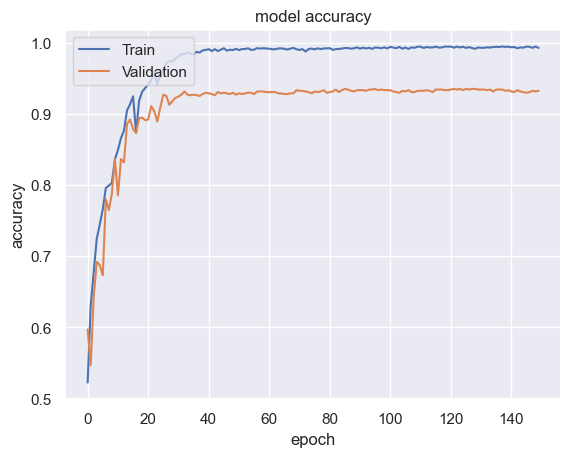

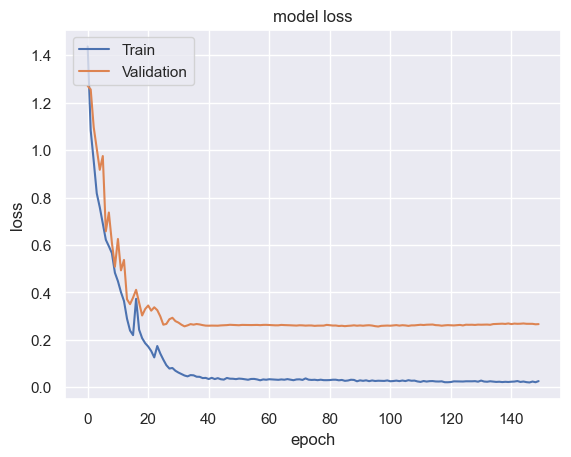

In [37]:
# Draw chart for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
sns.set()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Draw chart for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 4. Test 

In [42]:
# load the model
model = load_model("model.h5")

In [43]:
# make predictions
test_prediction = model.predict(X_test)
test_prediction = np.argmax(test_prediction, axis=1)

41/41 [==============================] - 0s 2ms/step


In [53]:
# define the real labels
test_real = np.argmax(y_test,axis=1)

In [47]:
# get the loss and accuracy of model's predictionon test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
# show it!
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 0.30358606576919556
Accuracy: 0.9251908659934998


In [61]:
# define a var for classes
classes = labels_df["class"].unique()

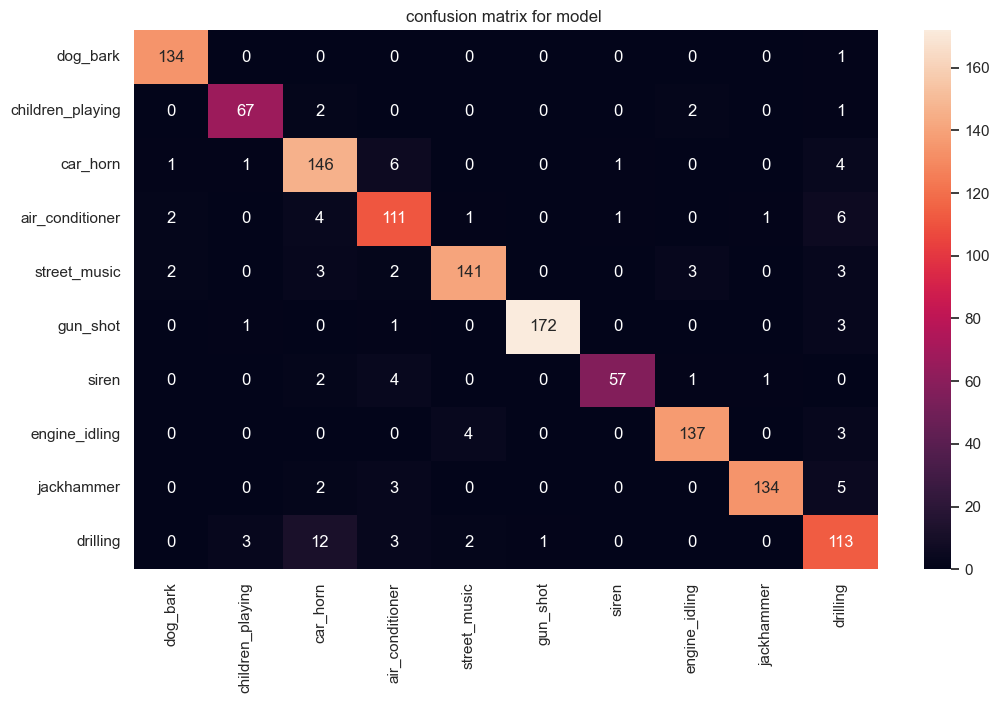

In [62]:
conf=confusion_matrix(test_real, test_prediction)
cm=pd.DataFrame(
    conf, index=[i for i in classes],
    columns=[i for i in classes]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()